In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import neural_network_lyapunov
import neural_network_lyapunov.relu_system as relu_system
import neural_network_lyapunov.lyapunov as lyapunov
import neural_network_lyapunov.pybullet_data_generation as pybullet_data_generation
import neural_network_lyapunov.dynamics_learning as dynamics_learning
import neural_network_lyapunov.encoders as encoders

import neural_network_lyapunov.test.train_2d_lyapunov_utils as train_2d_lyapunov_utils

import pybullet_data as pbd
def urdf_path(file):
    return os.path.join(os.path.dirname(neural_network_lyapunov.__file__), "urdf", file)

## Pendulum Settings

In [ ]:
dtype = torch.float64

# data
world_cb = pybullet_data_generation.load_urdf_callback(urdf_path("pendulum.urdf"))
joint_space = True

pybullet_x_lo = torch.tensor([-np.pi, -5.], dtype=dtype)
pybullet_x_up = torch.tensor([np.pi, 5.], dtype=dtype)
pybullet_noise = torch.tensor([.1, .1])
dataset_dt = .1
dataset_N = 5
grayscale = True
image_width = 48
image_height = 48
camera_eye_position = [0, -3, 0]
camera_target_position = [0, 0, 0]
camera_up_vector = [0, 0, 1]

# training
num_samples = 100
batch_size = 60
validation_ratio = .01
validation_rollouts_N = 15
validation_max_rollouts = 100

dyn_learning_opt = dynamics_learning.DynamicsLearningOptions()

dyn_learning_opt.dynynamics_loss_weight = 10.
dyn_learning_opt.lyapunov_loss_at_samples_weight = 1.
dyn_learning_opt.equilibrium_loss_weight = 10.

dyn_learning_opt.lyapunov_loss_freq = 1
dyn_learning_opt.lyapunov_loss_weight = 1.

dyn_learning_opt.V_lambda = 0.01
dyn_learning_opt.V_eps = 0.1

# encoder-decoder
encoder_class = encoders.LinearEncoder1
decoder_class = encoders.LinearDecoder1
use_bce = True
use_variational = False
z_dim = 5
z_lo = -1. * torch.ones(z_dim, dtype=dtype)
z_up = 1. * torch.ones(z_dim, dtype=dtype)

# dynamics nn
dyn_nn_width = 20
dyn_nn_depth = 1

# lyapunov nn
lyap_nn_width = 20
lyap_nn_depth = 1

## Cubes Settings

In [ ]:
def load_falling_cubes_callback():
    def cb(pb):
        plane_id = pb.loadURDF(urdf_path("plane_white.urdf"))
        pos = [0, 0, .25]
        orn = pb.getQuaternionFromEuler([0, 0, 0])
        cube1_id = pb.loadURDF(urdf_path("cube_blue.urdf"), pos, orn)
        pos = [0.03, 0, 0.025]
        cube2_id = pb.loadURDF(urdf_path("cube_red.urdf"), pos, orn)
        pos = [-.075, 0, 0.025]
        cube3_id = pb.loadURDF(urdf_path("cube_red.urdf"), pos, orn)
        return cube1_id
    return cb

dtype = torch.float64

# data
world_cb = load_falling_cubes_callback()
joint_space = False

pybullet_x_lo = torch.tensor([-.1, 0, .15, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=dtype)
pybullet_x_up = torch.tensor([.1, 0, .15, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=dtype)
pybullet_noise = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=dtype)
dataset_dt = .05
dataset_N = 10
grayscale = False
image_width = 128
image_height = 128
camera_eye_position = [0, -.5, .15]
camera_target_position = [0, 0, .1]
camera_up_vector = [0, 0, 1]

# training
num_samples = 100
batch_size = 60

validation_ratio = .01
validation_rollouts_N = 10
validation_max_rollouts = 10

dyn_learning_opt = dynamics_learning.DynamicsLearningOptions()

dyn_learning_opt.dynynamics_loss_weight = 10.
dyn_learning_opt.lyapunov_loss_at_samples_weight = 1.
dyn_learning_opt.equilibrium_loss_weight = 10.

dyn_learning_opt.lyapunov_loss_freq = 1
dyn_learning_opt.lyapunov_loss_weight = 1.

dyn_learning_opt.V_lambda = 0.01
dyn_learning_opt.V_eps = 0.1

# encoder-decoder
encoder_class = encoders.CNNEncoder1
decoder_class = encoders.CNNDecoder1
use_bce = True
use_variational = False
z_dim = 8
z_lo = -1. * torch.ones(z_dim, dtype=dtype)
z_up = 1. * torch.ones(z_dim, dtype=dtype)

# dynamics nn
dyn_nn_width = 20
dyn_nn_depth = 1

# lyapunov nn
lyap_nn_width = 20
lyap_nn_depth = 1

## Cluttered Table Settings

In [64]:
def load_cluttered_table_callback():
    def cb(pb):
        flags = pb.URDF_ENABLE_CACHED_GRAPHICS_SHAPES & \
            pb.URDF_USE_SELF_COLLISION & \
            pb.URDF_USE_INERTIA_FROM_FILE
        table_height = .625

        pb.setAdditionalSearchPath(pbd.getDataPath())
        
        table_id = pb.loadURDF("table_square/table_square.urdf")

        pos = [0.04, 0.04, table_height]
        orn = [0.42, 0.56, 0.56, 0.43]
        duck_id = pb.loadURDF("duck_vhacd.urdf", pos, orn)

        pos = [0.01, -.1, 0.009 + table_height]
        orn = pb.getQuaternionFromEuler([0, 0, np.pi/4])
        block4_id = pb.loadURDF(urdf_path("block_green.urdf"), pos, orn)

        pos = [-.07, 0, 0.025 + table_height]
        orn = pb.getQuaternionFromEuler([0, 0, 0])
        cube_red = pb.loadURDF(urdf_path("cube_pink.urdf"), pos, orn, flags=flags)

        pos = [1, 1, .25 + table_height]
        orn = pb.getQuaternionFromEuler([0, 0, 0])
        cube_blue = pb.loadURDF(urdf_path("cubes_numbers/cube_0.urdf"),
                                pos, orn, flags=flags)

        return cube_blue
    return cb

dtype = torch.float64

# data
world_cb = load_cluttered_table_callback()
joint_space = False

pybullet_x_lo = torch.tensor([-.065, -.025, .25 + .625, -np.pi/4, -np.pi/4, -np.pi/4, 0, 0, 0, -3, -3, -3], dtype=dtype)
pybullet_x_up = torch.tensor([.065, .025, .25 + .625, np.pi/4, np.pi/4, np.pi/4, 0, 0, 0, 3, 3, 3], dtype=dtype)
pybullet_noise = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=dtype)

dataset_dt = .1
dataset_N = 5

grayscale = False
image_width = 256
image_height = 256

camera_eye_position = [0, -.5, .88]
camera_target_position = [0, 0, .725]
camera_up_vector = [0, 0, 1]

# training
num_samples = 500
batch_size = 40

validation_ratio = .01
validation_rollouts_N = 15
validation_max_rollouts = 50

dyn_learning_opt = dynamics_learning.DynamicsLearningOptions()

############

# dyn_learning_opt.dynynamics_loss_weight = 10.
# dyn_learning_opt.lyapunov_loss_at_samples_weight = 1.
# dyn_learning_opt.equilibrium_loss_weight = 1.

# dyn_learning_opt.lyapunov_loss_freq = 10
# dyn_learning_opt.lyapunov_loss_weight = 1.

############

# dyn_learning_opt.dynynamics_loss_weight = 10.
# dyn_learning_opt.lyapunov_loss_at_samples_weight = 1.
# dyn_learning_opt.equilibrium_loss_weight = 1.

# dyn_learning_opt.lyapunov_loss_freq = 0
# dyn_learning_opt.lyapunov_loss_weight = 0.

############

dyn_learning_opt.dynynamics_loss_weight = 10.
dyn_learning_opt.lyapunov_loss_at_samples_weight = 0.
dyn_learning_opt.equilibrium_loss_weight = 0.

dyn_learning_opt.lyapunov_loss_freq = 0
dyn_learning_opt.lyapunov_loss_weight = 0.

############

dyn_learning_opt.V_lambda = 0.
dyn_learning_opt.V_eps = 0.01

# encoder-decoder
encoder_class = encoders.CNNEncoder2
decoder_class = encoders.CNNDecoder2

use_bce = True
use_variational = False

z_dim = 6
z_lo = -1. * torch.ones(z_dim, dtype=dtype)
z_up = 1. * torch.ones(z_dim, dtype=dtype)

# dynamics nn
dyn_nn_width = 10
dyn_nn_depth = 1

# lyapunov nn
lyap_nn_width = 10
lyap_nn_depth = 1

## Generating data

In [5]:
pbsg = pybullet_data_generation.PybulletSampleGenerator(world_cb, joint_space, image_width=image_width, image_height=image_height,
                                                        grayscale=grayscale, dtype=dtype,
                                                        camera_eye_position=camera_eye_position,
                                                        camera_target_position=camera_target_position,
                                                        camera_up_vector=camera_up_vector)

In [ ]:
x_data, x_next_data, X_data, X_next_data = pbsg.generate_dataset(pybullet_x_lo, pybullet_x_up, dataset_dt, dataset_N, num_samples)

In [6]:
x_data_ = dynamics_learning.add_noise(x_data, pybullet_noise)
x_next_data_ = dynamics_learning.add_noise(x_next_data, pybullet_noise)
x_train_dataloader, x_validation_dataloader = dynamics_learning.get_dataloaders(x_data_, x_next_data_, batch_size, validation_ratio)

X_train_dataloader, X_validation_dataloader = dynamics_learning.get_dataloaders(X_data, X_next_data, batch_size, validation_ratio)

X_rollouts, x_rollouts = dynamics_learning.dataloader_to_rollouts(pbsg, x_validation_dataloader, dataset_dt, validation_rollouts_N,
                                                                  max_rollouts=validation_max_rollouts)

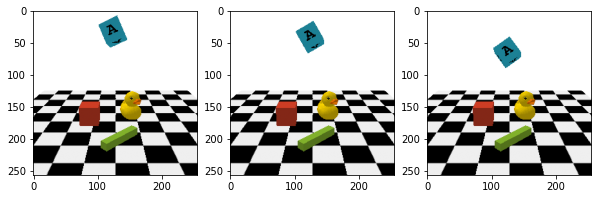

In [7]:
# plot some of the data
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data_generation.show_sample(X_data[i,:], X_next_data[i,:])

In [ ]:
i = np.random.choice(X_data.shape[0], 1)[0]
X_traj, x_traj = pbsg.generate_rollout(x_data[i,:], dataset_dt, 5)
for n in range(X_traj.shape[0]):
    pybullet_data_generation.show_sample(X_traj[n, :])

In [8]:
torch.save(x_data, "x_data")
torch.save(x_next_data, "x_next_data")
torch.save(X_data, "X_data")
torch.save(X_next_data, "X_next_data")

In [4]:
x_data = torch.load("x_data")
x_next_data = torch.load("x_next_data")
X_data = torch.load("X_data")
X_next_data = torch.load("X_next_data")

## Learning in state space

In [ ]:
dyn_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, z_dim, dyn_nn_width, dyn_nn_depth)
lyap_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, 1, lyap_nn_width, lyap_nn_depth)

relu_sys = relu_system.AutonomousReLUSystem(dtype, z_lo, z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)

dyn_learner = dynamics_learning.StateSpaceDynamicsLearning(x_train_dataloader, x_validation_dataloader, relu_sys, lyap, dyn_learning_opt)

In [ ]:
dyn_learner.train(10, validate=True)

In [ ]:
# plot a random rollout
x_traj = dyn_learner.rollout(x_data[np.random.choice(x_data.shape[0], 1)[0], :], 100)
plt.plot(x_traj)
plt.show()

In [ ]:
# validation over rollouts
dyn_learner.rollout_validation(x_rollouts)

## Learning in image space

In [65]:
dyn_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, z_dim, dyn_nn_width, dyn_nn_depth)
lyap_nn_model = dynamics_learning.get_ff_network(dtype, z_dim, 1, lyap_nn_width, lyap_nn_depth)

relu_sys = relu_system.AutonomousReLUSystem(dtype, z_lo, z_up, dyn_nn_model)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)
encoder = encoder_class(z_dim, image_width, image_height, grayscale)
decoder = decoder_class(z_dim, image_width, image_height, grayscale)

dyn_learner = dynamics_learning.LatentSpaceDynamicsLearning(X_train_dataloader, X_validation_dataloader, relu_sys, lyap, dyn_learning_opt,
                                                            encoder, decoder, use_bce=use_bce, use_variational=use_variational)

device = 'cuda'

In [11]:
import time
start = time.time()
dyn_learner.train_encoder(100, validate=True, device=device)
end = time.time()
print(end - start)

683.514984369278


In [59]:
torch.save(dyn_learner.encoder, "encoder")
torch.save(dyn_learner.decoder, "decoder")

In [66]:
dyn_learner.encoder = torch.load("encoder1002/encoder")
dyn_learner.decoder = torch.load("encoder1002/decoder")

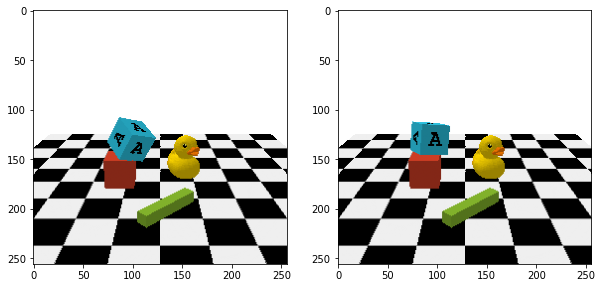

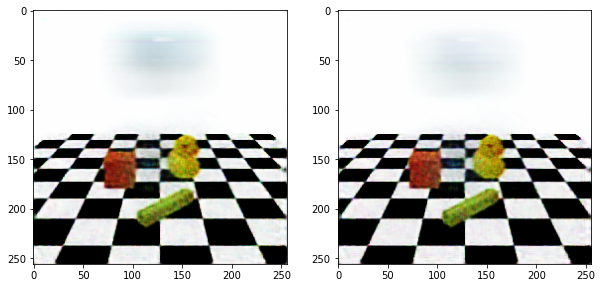

In [67]:
# plot some of the data
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data_generation.show_sample(X_data[i,:])
X_decoded, _, _ = dyn_learner.encode_decode(X_data[i,:].unsqueeze(0))
X_decoded = X_decoded.squeeze()
pybullet_data_generation.show_sample(X_decoded)

In [ ]:
# dyn_learner.dynynamics_loss_weight = 1.
# dyn_learner.lyapunov_loss_at_samples_weight = 1.
# dyn_learner.equilibrium_loss_weight = 1.
# dyn_learner.lyapunov_loss_freq = 1
# dyn_learner.lyapunov_loss_weight = 1.

In [26]:
import time
start = time.time()
dyn_learner.lyapunov_loss()
end = time.time()
print(end - start)

0.46437859535217285


In [ ]:
import time
start = time.time()
# dyn_learner.train(100, validate=True, device=device)
dyn_learner.train(115, validate=True, device=device)
end = time.time()
print(end - start)

In [60]:
torch.save(dyn_learner.relu_system.dynamics_relu, "dynamics")
torch.save(dyn_learner.lyapunov.lyapunov_relu, "lyapunov")

In [ ]:
dyn_learner.relu_system.dynamics_relu = torch.load("dynamics")
dyn_learner.lyapunov.lyapunov_relu = torch.load("lyapunov")

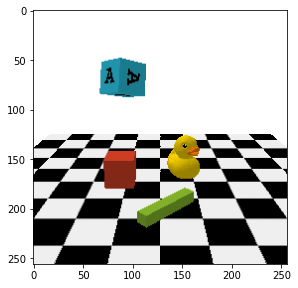

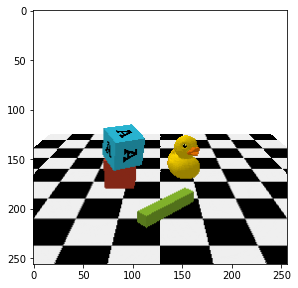

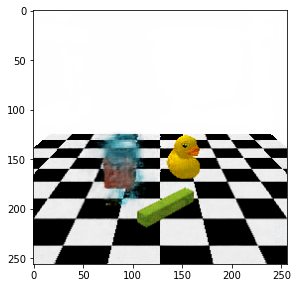

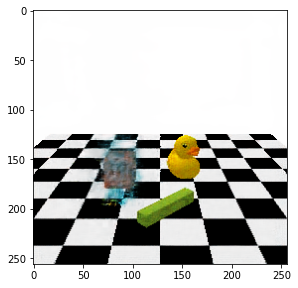

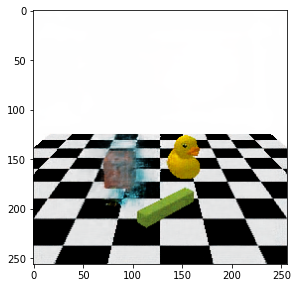

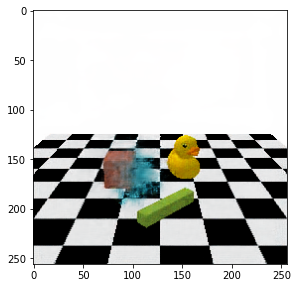

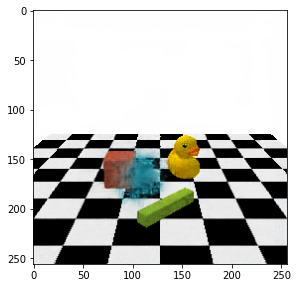

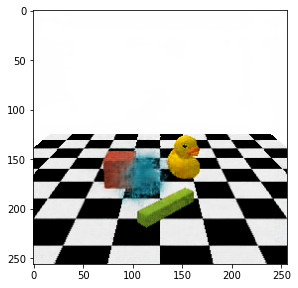

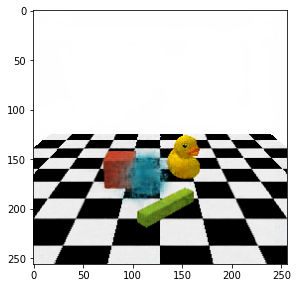

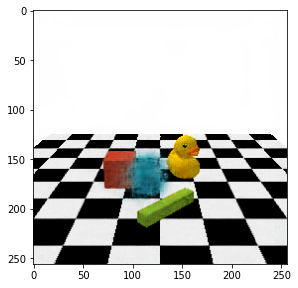

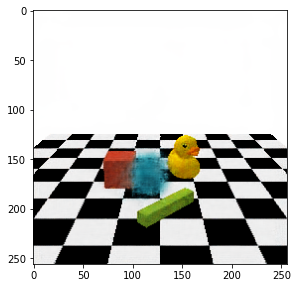

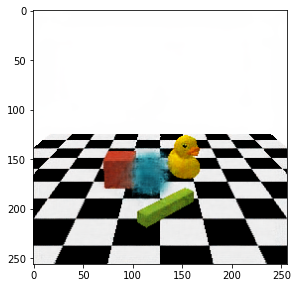

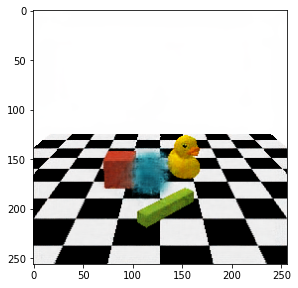

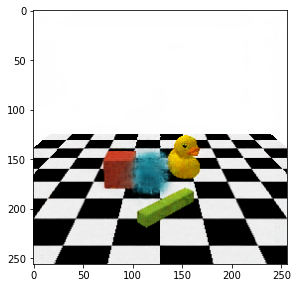

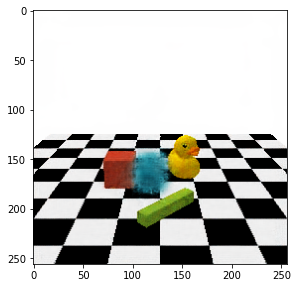

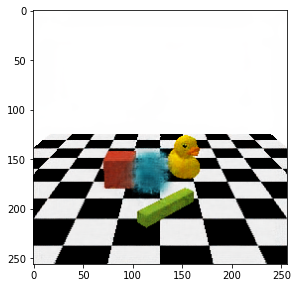

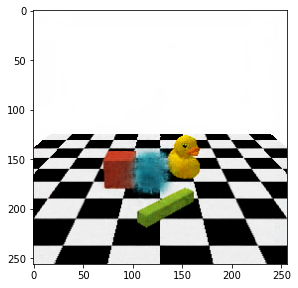

In [50]:
# plot a random rollout
i = np.random.choice(X_data.shape[0], 1)[0]
x_traj = dyn_learner.rollout(X_data[i, :], validation_rollouts_N)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])

In [ ]:
x_traj, _ = pbsg.generate_rollout(x_data[i, :], dataset_dt, validation_rollouts_N)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])

In [ ]:
# validation over rollouts
dyn_learner.rollout_validation(X_rollouts)

In [52]:
z_adv_pos, z_adv_der = dyn_learner.adversarial_samples()

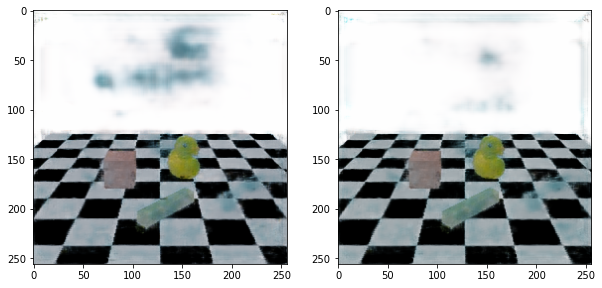

In [61]:
z_adv = z_adv_pos
# z_adv = z_adv_der
i = np.random.choice(z_adv.shape[0], 1)[0]
X_adv = dyn_learner.decoder(z_adv[i, :].unsqueeze(0))[0, :]
pybullet_data_generation.show_sample(X_adv)

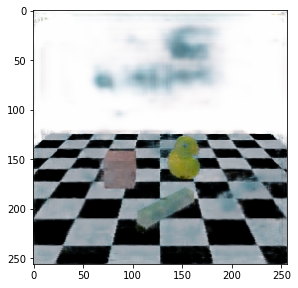

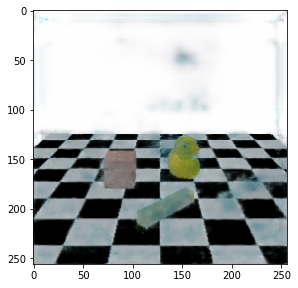

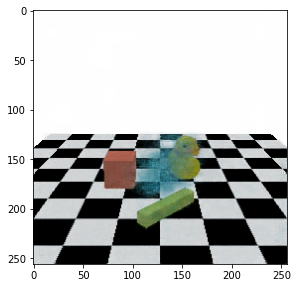

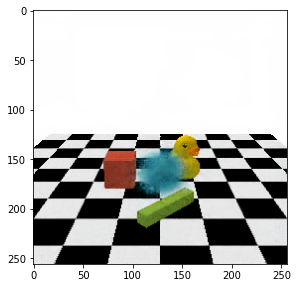

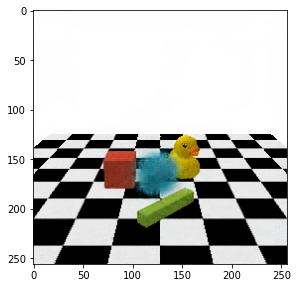

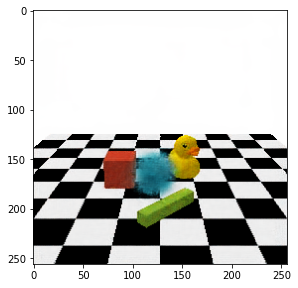

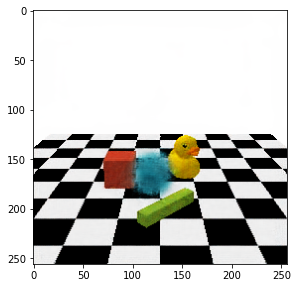

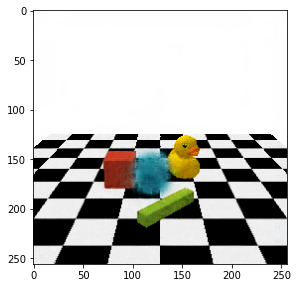

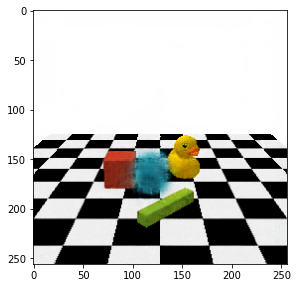

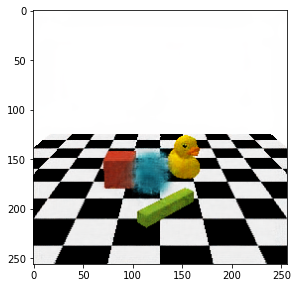

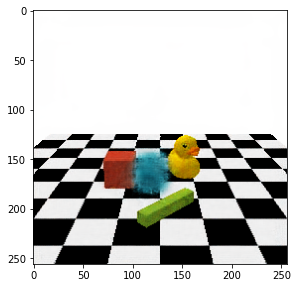

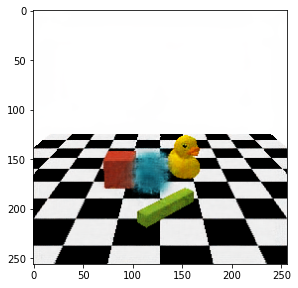

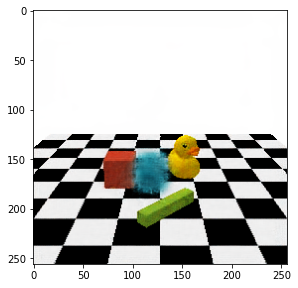

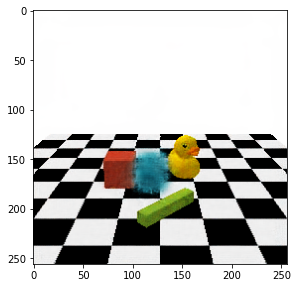

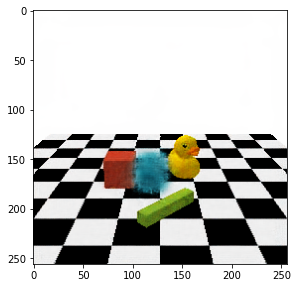

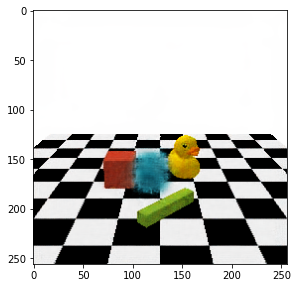

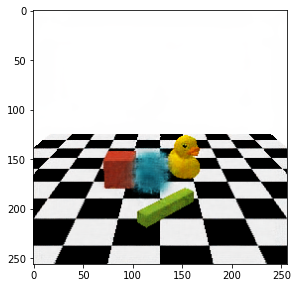

In [62]:
x_traj = dyn_learner.rollout(X_adv, validation_rollouts_N)
for n in range(x_traj.shape[0]):
    pybullet_data_generation.show_sample(x_traj[n, :])